----------------------------------------------------------------------------------------------------------
***********************************************************************************************************

# <span style="color:Purple"> From Shallow to Deep Learning 

#### Second Project: Image Retrieval BoVW or CNN

#### Author: Lynda Attouche
#### Link: https://drive.google.com/file/d/1yDLJy3EBLCfw0LDqE9Jx44vGpHsrqGQj/view?usp=sharing
***********************************************************************************************************
----------------------------------------------------------------------------------------------------------


In [55]:
#update opencv version 
!pip install opencv-contrib-python==4.5.5.62

In [56]:
!pip install faiss-cpu --no-cache

## 1. Imports

In [57]:
# libraries and module
import os
from google.colab import drive
import random
import cv2 as cv
import tqdm.notebook as tq
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import torchvision.datasets as datasets
import  torch.utils

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import operator

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
from keras.models import Sequential
from keras.utils.vis_utils import plot_model

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sn
import math as m
import numpy.ma as ma
from skimage.transform import resize
from keras.applications.vgg16 import VGG16
import faiss
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import plot_confusion_matrix, confusion_matrix


## Loading data

In [58]:
drive.mount('/content/drive') 
path = "/content/drive/My Drive/Datasets/VOC2007"
voc_trainset = datasets.VOCDetection(path,year='2007', image_set='train', download=False)
annotation_path = path+"/VOCdevkit/VOC2007/ImageSets/Main/"
print(os.listdir(annotation_path))
image_path = path+"/VOCdevkit/VOC2007/JPEGImages/"
all_images = os.listdir(image_path)
all_images[0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['train.txt', 'val.txt', 'trainval.txt', 'bicycle_train.txt', 'bicycle_val.txt', 'bicycle_trainval.txt', 'aeroplane_trainval.txt', 'aeroplane_val.txt', 'aeroplane_train.txt', 'boat_val.txt', 'bird_train.txt', 'bird_val.txt', 'bird_trainval.txt', 'boat_train.txt', 'boat_trainval.txt', 'bottle_val.txt', 'bottle_train.txt', 'bus_val.txt', 'bottle_trainval.txt', 'bus_train.txt', 'bus_trainval.txt', 'cat_train.txt', 'cat_trainval.txt', 'car_trainval.txt', 'car_val.txt', 'cat_val.txt', 'car_train.txt', 'cow_train.txt', 'cow_val.txt', 'cow_trainval.txt', 'chair_trainval.txt', 'chair_val.txt', 'chair_train.txt', 'diningtable_train.txt', 'diningtable_val.txt', 'dog_val.txt', 'diningtable_trainval.txt', 'dog_trainval.txt', 'dog_train.txt', 'horse_val.txt', 'horse_train.txt', 'horse_trainval.txt', 'motorbike_trainval.txt', 'person_trainval.txt', 'motorbike_val.txt', 'pe

'009868.jpg'

In [59]:
def images(file):
  """
    Loading images from a given file
    @params:
            - file (string): file name
    @return:
            - list of images
  """
  x = open(annotation_path+file).read().splitlines()
  xs =[x[i].split(" ") for i in range(len(x))]
  images = []
  tmp=0
  for i in range(len(xs)):
    if len(xs[i])==2:
      tmp = xs[i][1]
    else:
      tmp = xs[i][2]
    if tmp == '1':
      images.append(xs[i][0]+'.jpg')
  return images

For this project I decided to work with 3 categories: aeroplanes, horses and tv monitors. So, the first thing to do is uploading the images using their specific files from our image folder. This is done by the function above and then these images will be merged to form one and only dataset. If we look at the files, we have train and validation data. Both of them will be uploaded. Indeed, I decided to work with a defined train set and validation set from the beginning. herefore I won't have to separate (split the data) them during the training phase.

This has been done in the following cells:

To avoid having imbalanced data, I decided to select samples of same size (=100) for all the categories as follows

In [60]:
#Loading the images

#Train images:
aeroplanes_train = images('aeroplane_train.txt')[0:100]
horses_train = images('horse_train.txt')[0:100]
tvmonitor_train = images('tvmonitor_train.txt')[0:100]

#Validation images:
aeroplanes_val = images('aeroplane_val.txt')[0:100]
horses_val = images('horse_val.txt')[0:100]
tvmonitor_val = images('tvmonitor_val.txt')[0:100]

In [61]:
#Building dataset

#Train set
#merging the 3 subsets of train images of: horses, aeroplanes,tvmonitors
data_train = horses_train +tvmonitor_train +aeroplanes_train
random.shuffle(data_train)
random.shuffle(data_train)

#Validation set
#merging the 3 subsets of validation images of: horses, aeroplanes,tvmonitors
data_val = horses_val+tvmonitor_val+aeroplanes_val
random.shuffle(data_val)
random.shuffle(data_val)

To make it easier to get the label of a lambda image at any time when we need it, the following function associates a label to each image of our datasets

In [62]:
def get_label(idx,data):
  """
      Assign a label to each image of a category
      @params:
              - idx (int): index of the image in the dataset
              - data (list) : images in the dataset
      @return: 
              - image label (int) and 'unk' if unknown 

  """ 
  if data[idx] in aeroplanes_train or data[idx] in aeroplanes_val:
    return 0
  if data[idx] in horses_train or data[idx] in horses_val:
    return 1
  if data[idx] in tvmonitor_train or data[idx] in tvmonitor_val:
    return 2
  else:
    return 'unk'

In [63]:
#labels for each images in the train set
train_labels = [get_label(i,data_train) for i in range(len(data_train)) ]
#labels for each images in the validation set
val_labels = [get_label(i,data_val) for i in range(len(data_val))]

#### Examples

Examples from validation set:
Category of the image:  0


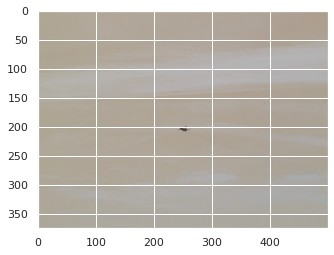

Examples from validation set:
Category of the image:  1


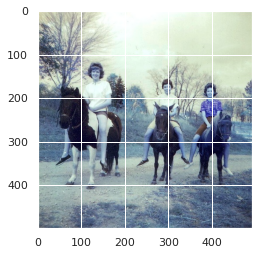

Examples from validation set:
Category of the image:  0


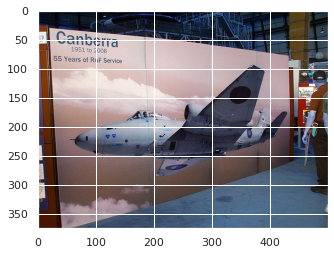

Examples from validation set:
Category of the image:  1


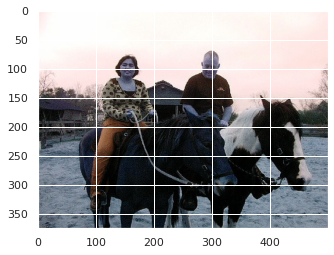

Examples from validation set:
Category of the image:  1


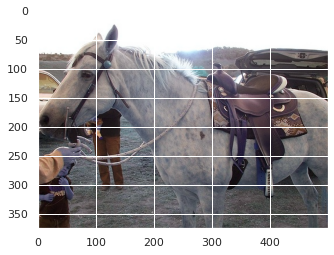

Examples from validation set:
Category of the image:  2


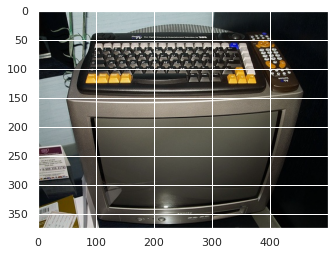

Examples from validation set:
Category of the image:  1


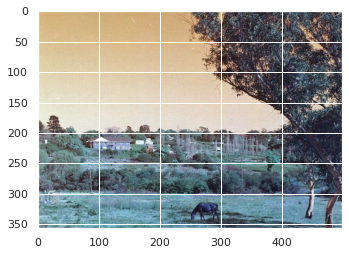

In [64]:
for i in range(20,27):
  #test on train set
  if i<3:
    print("Examples from train set:")
    print("Category of the image: ",train_labels[i+20])
    im = cv.imread(image_path+data_train[i+20])
    plt.imshow(im)
    plt.show()
  #test on validation set
  if i>=3:
    print("Examples from validation set:")
    print("Category of the image: ",val_labels[i+20])
    im = cv.imread(image_path+data_val[i+20])
    plt.imshow(im)
    plt.show()

## First Task: Extend Near Duplicate to Classification
---






The goal of this first task is: from an image belonging to a specific category, retrieve the images belonging to the same category based on a well-chosen threshold (optimal for the task) 

### Helper functions (from first project)

In order to do this, we will rely on functions from the previous project to find points, descriptors and good matches between images. 

In [65]:
def KpDes(image):
  """
  Detects keypoint in a given image ad computes the descriptors
  @params:
  -image(array): image on which we work
  @return:
  -kp(list): contains the detected keypoints in the image
  -des(array): contrains the descriptors
  """
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create()
  kp, des = sift.detectAndCompute(image,None)
  return kp,des

########################################
def matching(img1,img2):
  """
    Computes matches between 2 images
    @params:
            - img1 (array): query image
            - img2 (array): train image
    @return:
            - matches (list):  matches between the images
            - kp1,kp2 (lists): keypoints of each image
  """
  kp1, des1 = KpDes(img1) 
  kp2, des2 = KpDes(img2)
  bf = cv.BFMatcher()
  matches = bf.knnMatch(des1,des2, k=2)
  return matches,kp1,kp2
########################################
def GoodMatches(img1,img2):
  """
    Computes matches between 2 images
    @params:
            - img1 (array): query image
            - img2 (array): train image
    @return:
            - best_matches (list):  best_matches between the images
            - kp1,kp2 (lists): keypoints of each image
  """
  matches,kp1,kp2 = matching(img1,img2)
  best_matches = []
  ratio = 0.6
  for m1,m2 in matches:
    if m1.distance < ratio*m2.distance:
      best_matches.append([m1])
  number_keypoints = min(len(kp1),len(kp2))
  score = float(len(best_matches) / number_keypoints)*100
  return best_matches,kp1,kp2,score

In [66]:
#Loading images as arrays

#train set
train_images = [cv.imread(image_path+data_train[i]) for i in range(len(data_train))]
#validation set
val_images = [cv.imread(image_path+data_val[i]) for i in range(len(data_val))]

I considered in the following, the threshold to be the lower limit for the score. That is, having the similarity score between the query image and any other (computed using the function GoodMatches), if it is above the threshold we consider the image as a retrieved image. 
This is done for any image in the dataset to which the query image belongs. At the end, a list containing each retrieved image and its category is returned.

This is done using the following function:

In [67]:
def retrieve_by_category(query,query_idx,threshold):
  """
  Retrieved images belonging to the same category of a given image
  @params:
          - query (array) : query image
          - query_idx (int): index of the query image in the dataset
          - threshold (float): threshold 
  @return:
          - retrieved (list): list of the retrieved images
  """
  category = train_labels[query_idx]
  retrieved = []
  # for each image 
  for i in tqdm(range(len(train_labels))):
    if i != query_idx:
      matches,kp1,kp2,score = GoodMatches(query,train_images[i])
      cat = train_labels[i]
      #test if the similarity score is above the threshold
      if score > threshold:
        #add the image to the list
        retrieved.append((i,cat))
  return retrieved 

A number of thresholds is tested in order to find the most optimal one, and this is carried out as follows:

In [68]:
thresholds = [0.3,0.4,0.5,0.6,0.7,0.8,0.9] #different thresholds to be tested

In order to compare these thresholds, a metric is needed. The accuracy given by the number of retrieved images over all the images of the dataset is used to evaluate. But also, the percentage of retrieved images that are of the same category as the query image relative to the total images of that category in the dataset

In [69]:
def eval_metric(retrieved,query_cat):
  """
  Computes the accuracy of the method
  @params: 
        - retrieved (list): retrieved images
        - query_cat (int): category of the query image
  @return:
        - accuray (float)
  """
  tp = 0 #true positive
  #for each retrieved image
  for im in tqdm(retrieved):
    cat = train_labels[im[0]] #get the category of the retrieved image
    if cat==query_cat: #if it is equal to the query category (the one we are looking for)
      tp += 1 #it means the retreive is good, increase then the true positive  value
  return tp, len(retrieved)/len(train_labels)

In [70]:
def eval_retrieving(idx):
  """
    Evaluates the retrieving images process for each threshold
    @params:
            - idx (int): index of the query image
    @return: 
            - dataframe 
  """
  queryImage = train_images[idx] #query image
  #this following list contains the retreived images for each threshold
  retrieved = [retrieve_by_category(queryImage,4,t) for t in thresholds]
  idx = train_labels[idx]
  #the number of good retrieved image among all the images
  eval = [eval_metric(retrieved[i],idx)[1] for i in range(len(retrieved))]
  #number of images retrieved among all the images belonging to the query categoory
  tps = [(100*eval_metric(retrieved[i],idx)[0])/299 for i in range(len(retrieved))]
  df = pd.DataFrame(list(zip(thresholds, eval, tps)),
               columns =['Threshold', 'Accuracy','% images'])
  return df

In [71]:
print("Retrieving for aeroplane category")
df1 = eval_retrieving(6)
print(df1)
print("Retrieving for horses category")
df2 = eval_retrieving(9)
print(df2)
print("Retrieving for tv monitors category")
df3 = eval_retrieving(1)
print(df3)

Retrieving for aeroplane category


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

   Threshold  Accuracy   % images
0        0.3  0.353333  13.712375
1        0.4  0.353333  13.712375
2        0.5  0.353333  13.712375
3        0.6  0.353333  13.712375
4        0.7  0.353333  13.712375
5        0.8  0.353333  13.712375
6        0.9  0.353333  13.712375
Retrieving for horses category


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

   Threshold  Accuracy   % images
0        0.3  0.406667  11.036789
1        0.4  0.400000  11.036789
2        0.5  0.290000   7.023411
3        0.6  0.280000   7.023411
4        0.7  0.210000   3.344482
5        0.8  0.193333   3.010033
6        0.9  0.153333   1.672241
Retrieving for tv monitors category


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

   Threshold  Accuracy  % images
0        0.3  0.430000  6.020067
1        0.4  0.360000  4.347826
2        0.5  0.306667  3.678930
3        0.6  0.273333  3.344482
4        0.7  0.260000  3.010033
5        0.8  0.213333  2.341137
6        0.9  0.183333  2.006689


Results analysis
* The first thing to notice is that during the process, the computation time is quite important despite the small dataset on which it has been tested. This makes sense because it takes time just to compute the matches between images. So we cannot even imagine the time it will take for a dataset containing more than 1000, 10000 images or more... Exponential!  

* Looking at the dataframe above, it can be seen that some thresholds give different results and capture only a small part of the total images. For example, for the class aeroplannes:

  -- For a threshold of 0.9: the accuracy is 18% which is really weak and belong these retrieved images only 2% of the images belong to the query category (which we have in total in the dataset). 

    By analyzing these results, we can conclude that the optimal threshold for the score is 0.3 because it has an accuracy of 43% and it is the highest one but still only 6% belong to the query category.
Despite this choice of threshold, the results remain very low. 

  The results are even lower for the the tvmonitor class. This method hardly retrieves the desired class. However, the result on the horses category are quite better.
  Thus, this method is therefore not flexible at all. And it does not fit all categories, mainly when the category is sensitive 


In conclusion, this method is time consuming and its accuracy is poor.




## Second Task: Bag-of-Word model for Image Classification


---




As found, the previous method was not efficient either in time or in accuracy. This is why the aim of this second task is to build a more efficient search engine based on the Bag of Visual Words

### 1-2) Computing keypoints and descriptors

First, the keypoints and descriptors of each image in the dataset are calculated. These descriptors will be given and used by the Kmeans algorithm.

In [72]:
def descriptors(data,images):
  """
  Computes descriptors and keypoints of the images in a dataset
  @param:
        - data(list): list of images
        - images(list): images of the dataset in array format
  @return: 
        - descriptors(array): descriptors
        - tot(list): list of tuple (image name,descriptors)
  """
  #extracting keypoints and descriptors
  tot = []
  for i in range(len(data)):
    kp,des = KpDes(images[i])
    tot.append((data[i],des))
  des = [tot[i][1] for i in range(len(tot))]
  #initialize with the descriptors of the first image
  descriptors=tot[0][1]
  # add the other descriptors starting from the 2nd 
  for img,descriptor in tot[1:]:
    descriptors=np.vstack((descriptors,descriptor))
  return descriptors,tot

In [73]:
#descriptors computation
#train set
train_des,train_tot = descriptors(data_train,train_images)
#validation set
val_des,val_tot = descriptors(data_val,val_images)

### 3) Clustering using K-means algorithm



Let's move on to the KMeans algorithm. Since the classic KMeans algorithm takes time. A faster version is used, the one given in the project statement, whose implementation can be summarised in the following class

In [74]:
class FaissKMeans:
    def __init__(self, n_clusters, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X, y=None):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return np.squeeze(self.kmeans.index.search(X.astype(np.float32), 1)[1], -1)

The first thing to do is to choose the number of clusters. This is not explicit. After several tests (20,30,40,....,100,150,200) on my dataset, it turned out that the number k = 100 is the most efficient and therefore the one used.

In [75]:
K = 100
fkmeans = FaissKMeans(n_clusters = K)
fkmeans.__init__(n_clusters = K)

The application of the KMeans on the training set is done by passing the previously calculated training set descriptors concatenated to the validation set descriptors to the fit function and then predict on each one. The concatenation is done to be sure of having all the visual words in the datasets.

In [76]:
fkmeans.fit(np.concatenate((train_des,val_des)))

Now the fitting is done, let's predict on the train set:

In [77]:
#all the words in the train
train_pred = fkmeans.predict(train_des)
train_pred.shape

(213504,)

The same thing is done on the validation set as follows:

In [78]:
#all the words in the train
val_pred = fkmeans.predict(val_des)
val_pred.shape

(219644,)

### 5) Image histogram

The K-MEans algorithm allows to assign to each visual word a cluster. Then, the goal is to create/define a histogram for each image representing its content, i.e. the visuals words constituting it. In other words, build a histogram from the clustering of the descriptors. If we think of the histogram as a bar plot, each bar represents the number of visual words in the image belonging to the cluster defining it.

In [79]:
def histoFeatures(data,tot,voc_pred):
  """
    Computes histograms of images in the dataset
    @params:
            - data (list): dataset of images
            - tot (list): list of (image,descriptors)
            - voc_pred(array): clustering returned by the kmeans function
    @return
          - histos (array): containing histograms for the dataset images
  """
  histos = np.zeros((len(data),K)) #all histograms (for all image)
  prev_img = 0 #will contains the number of descriptors of the image that precedes the current image
  #the variable will helps us to move through the descriptors in voc_pred
  #for each image i 
  for i in tqdm(range(len(data))):
    #descriptors of image i
    des = tot[i][1]
    #predictions on all the descriptors of image
    #starts when the previous one finish and end when all the descriptors are selected
    #example: image 1 has 374 descriptors and it is preceded by the image 0 that has 3 descriptors
    #so, pred = [len(descriptors image 0):len(descriptors image 0)+len(descriptors image 1)]
    #thus: pred = [3:377]
    pred = voc_pred[prev_img:prev_img+len(des)]
    #how many descriptor in each cluster
    for cl in range(K):
        histos[i][cl] = np.sum(pred==cl) #the sum gives the total number of words assigned to the current cluster
    prev_img += len(des)
  return histos

In [80]:
def hist_im(idx,histo,data_image,tot):
  """
  Plots a histogram of a given image and the image
  @params:
          - idx(int): index of the image
          - histo(array): histograms of the images of the dataset (where the image belongs)
          - data_image (list): list of images as array
          - tot (list) : list of (image name, descriptors)
  @return: 
          plotting image and histogram
  """
  print('Image:')
  plt.figure(figsize = (15,5))
  plt.imshow(data_image[idx])
  plt.show()
  print('Number of descriptors of the image is: ',len(tot[idx][1]))
  x_scalar = np.arange(K)
  sn.set(rc = {'figure.figsize':(25,7)})
  sn.barplot(x_scalar, histo[idx])
  plt.xlabel("clusters")
  plt.ylabel("Number of descriptors")
  plt.title("Histogram of visual contents of the image: "+tot[idx][0])
  plt.xticks(x_scalar + 1, x_scalar)
  plt.show()

Computing the histogram of the images:
for each image, a histogram is computed! Each one has a length of 100 corresponding to 100 clusters

In [81]:
#Histogram of images of the trainset
train_histograms = histoFeatures(data_train,train_tot,train_pred)
#Histogram of images of the validation set
val_histograms = histoFeatures(data_val,val_tot,val_pred)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Examples

Image:


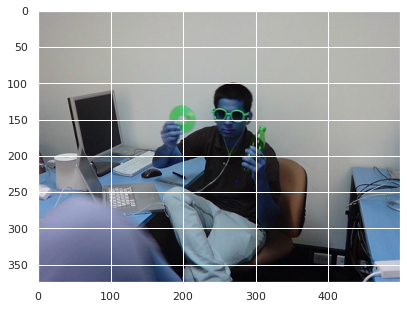

Number of descriptors of the image is:  309


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


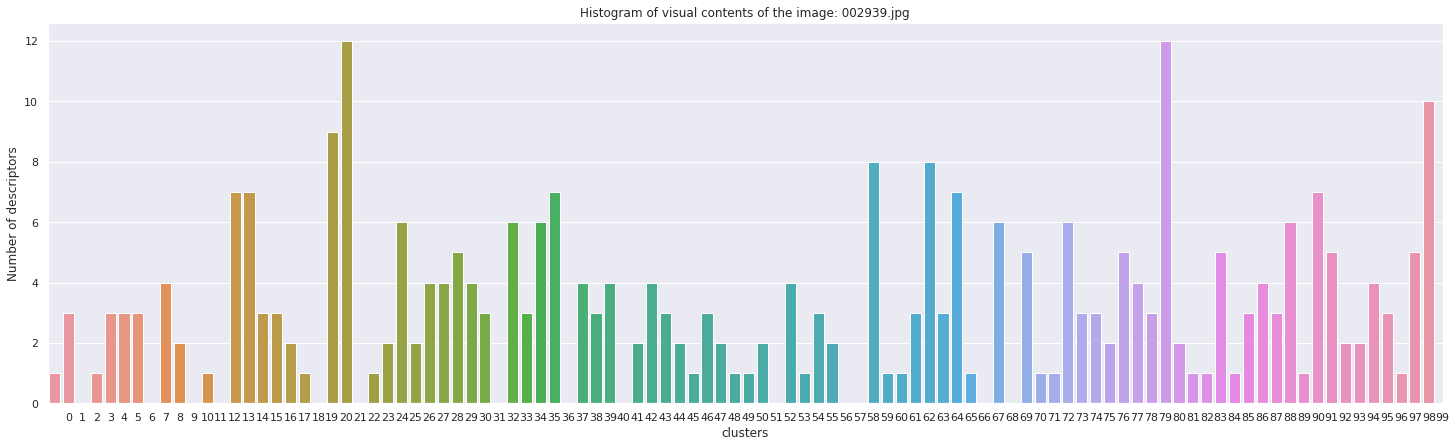

In [82]:
#image from trainset
hist_im(0,train_histograms,train_images,train_tot)

Image:


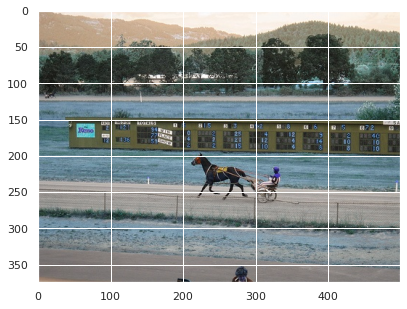

Number of descriptors of the image is:  1141


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


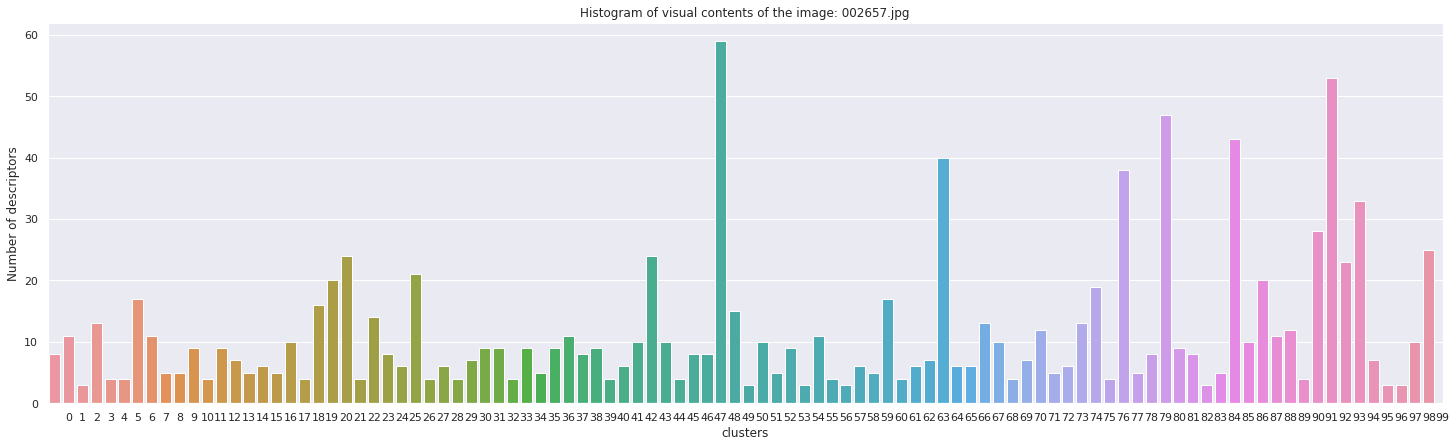

In [83]:
#image from validation set
hist_im(1,val_histograms,val_images,val_tot)

In [84]:
train_histograms

array([[ 1.,  3.,  0., ...,  1.,  5., 10.],
       [ 7., 14., 11., ..., 18., 11.,  9.],
       [ 3.,  2.,  5., ...,  4.,  9.,  4.],
       ...,
       [ 3.,  3.,  1., ...,  6.,  6.,  2.],
       [10., 15., 10., ...,  8., 12., 11.],
       [ 0.,  7.,  3., ...,  6., 12., 12.]])

In [85]:
val_histograms

array([[ 1.,  0.,  8., ...,  3.,  8.,  9.],
       [ 8., 11.,  3., ...,  3., 10., 25.],
       [ 5.,  4.,  3., ...,  0.,  5.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  4.,  0.],
       [ 1.,  3.,  4., ...,  1., 12.,  1.],
       [ 0.,  0.,  2., ...,  0.,  2.,  0.]])

From the previous examples, we can see a non-homogenous distribution of descriptors, some clusters contains a high number and other a very low

### 6) Reweighting histograms using TF-IDF

When words appear in a lot of images, they become irrelevant and make the task of classification even more difficult. In order to avoid this problem we normalize the histogram of the images using tf-idf. 

To fully understand the theory behind tf-idf and how to use it, I read up on it on these 2 websites: 
https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558 

https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/

and adapted it to visual words. 

Thus, each word in the new reweighted histogram will be calculated as follows:
$t_{i} = TF(t_{i}, image) \times  log(DF(t_{i}))$

where:
* $TF(t_{i}, image)$ is the frequency of the visual word in the image. It is given by dividing the number of occurence of the word in the image by the total number of words in that image
* $DF(t_{i})$ is the frequency of the visual word in the dataset (all images). It is given by the number of images where the visual word appears devided by the total number of images.IDF is the inverse of DF, that is why the log of DF is taken in the formula


In [86]:
def reweighting(histos):
  """
    Reweightes/Normalizes histograms
    @params:
          - histos (array): histograms in the dataset
    @params:
          - normalized histograms (array)
  """
  reweighted = np.zeros(histos.shape)
  num_histo = histos.shape[0] #number of images
  w = np.sum(histos > 0, axis=0) # number of occurences of words
  for i in range(num_histo): #for each histo
    wi = np.sum(histos[i])  #number of words in image i
    for cl in range(len(histos[i])): #for each cluster
      reweighted[i,cl] = histos[i,cl]/wi*np.log(num_histo/w[cl])
  return reweighted

Normalizing the previous histograms

In [87]:
#reweighted train histograms
train_rew_histograms = reweighting(train_histograms)
#reweighted validation histograms
val_rew_histograms = reweighting(val_histograms)

Examples

Image:


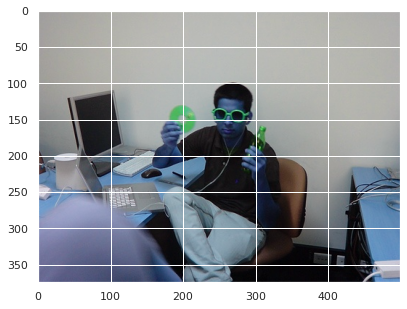

Number of descriptors of the image is:  309


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


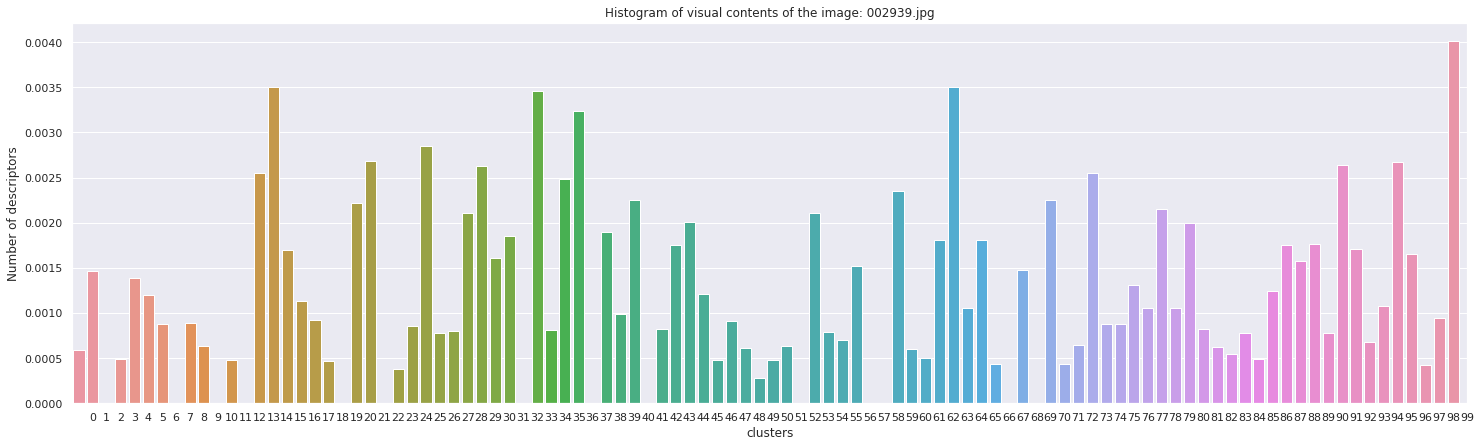

In [88]:
hist_im(0,train_rew_histograms,train_images,train_tot)

Image:


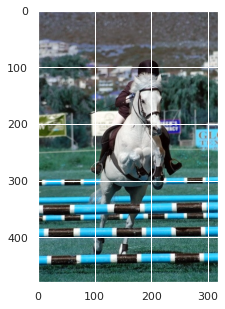

Number of descriptors of the image is:  1375


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


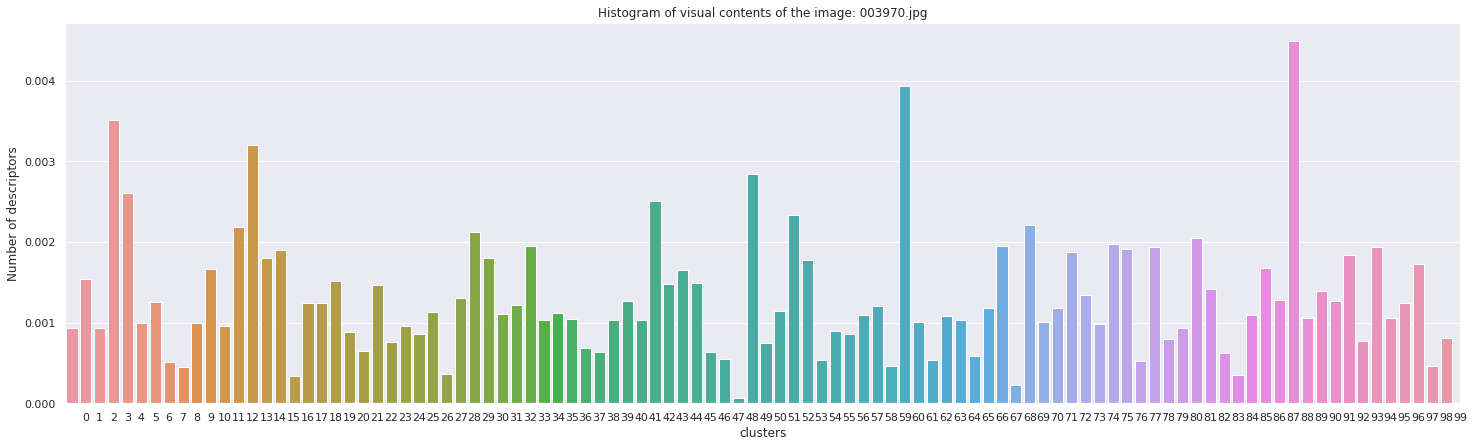

In [89]:
hist_im(1,train_rew_histograms,train_images,train_tot)

In [90]:
train_rew_histograms

array([[0.00059004, 0.0014643 , 0.        , ..., 0.00042598, 0.00094394,
        0.00401465],
       [0.00092818, 0.00153565, 0.00093227, ..., 0.00172314, 0.00046668,
        0.00081198],
       [0.00087514, 0.00048263, 0.00093227, ..., 0.00084242, 0.00084003,
        0.00079394],
       ...,
       [0.00106621, 0.00088201, 0.00022716, ..., 0.00153951, 0.00068229,
        0.00048364],
       [0.00160636, 0.00199325, 0.00102673, ..., 0.00092778, 0.00061676,
        0.00120227],
       [0.        , 0.00176254, 0.00058364, ..., 0.00131848, 0.00116866,
        0.00248519]])

In [91]:
val_rew_histograms

array([[0.00035197, 0.        , 0.0015701 , ..., 0.00085109, 0.00073808,
        0.00241961],
       [0.00127833, 0.00160467, 0.0002673 , ..., 0.00038638, 0.00041885,
        0.00305132],
       [0.00284877, 0.0020806 , 0.0009531 , ..., 0.        , 0.00074673,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00955813,
        0.        ],
       [0.00032269, 0.0008838 , 0.00071974, ..., 0.0002601 , 0.00101502,
        0.00024648],
       [0.        , 0.        , 0.00203327, ..., 0.        , 0.00095581,
        0.        ]])

### 7-8) Classification using neural network

To classify the images according to their categories (aeroplanes, horses, tvmonitor), we use the normalized histograms of these images calculated previously. And for the classification model, a neural network has been implemented. This neural network will get the histogram as input data: train histogram and validation histogram with the corresponding label. It is defined as follows:


#### a) Network architecture

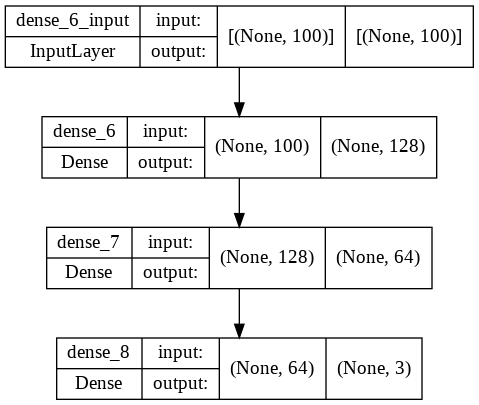

In [92]:
vocabulary_size = K #Number of clusters computed (the number of "words" in the dictionary)
n_classes = 3 #Number of classes (labels) of the original dataset
# Design the model (you can play with layer size and add/remove layers if you want to improve it)
model = Sequential()
model.add(Dense(128, input_dim=vocabulary_size, activation='relu')) # vocabulary_size is the size of your dictionary (n_clusters)
model.add(Dense(64, activation='relu'))

model.add(Dense(n_classes, activation='softmax')) # n_classes depends on the number of categories you chose (shape of one hot encoded y)

plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)

We can see that the neural network consists of 3 fully connectd layers described as follows: 
* **1st Layer**: it has as input the number of words in the vocabulary which corresponds to the number of clusters and as output the dimension 128. As activation function we find the function "ReLu".
* **2nd Layer**: it takes as input the output of the previous layer (since the model is sequential) and has as output a dimensiion of 64. And with the same activation function as before 
* **3rd Layer** : the last layer which for the same reason, its input is of dimension 64 and has as output the number of categories, i.e. 3. And since it is a multi-class classification the "Softmax" activation function has been used.

The choice of the number of neurons for each layer was made after a series of tests to get the best accuracy. And it turned out that the chosen values were the most satisfactory

#### b) Compilation and production

Now, to compile and produce the neural network
the following is used: 

* 1) **Loss:** since this is a multi-class classification, the loss "categorical_crossentropy" has been used.
* 2) **Optimizer:** 
The adam optimizer was found to be the most efficient 
* 3) **Metric**: as evaluation metric, accuracy was chosen 

In [93]:
# Compile the model (again, you can change loss, optimizer and metrics if you think you can improve it)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

#### c) Training neural network

For training the neural network, the hyperparameters and regularizers are:
* **The number of epochs**: 100
* **The batch size**: 64
* **Early stopping**: it allows a regularization of the network. More precisely, it allows to stop the training when the performance of the neural network starts to decrease.  

In [94]:
X_train= np.array(train_rew_histograms)
X_val =  np.array(val_rew_histograms)

# Convert categorical data to binary array (creating label vector to learn the similarity)
y_train = np.array(train_labels)
y_train = y_train.reshape(-1,1)
ohe = OneHotEncoder()
y_train = ohe.fit_transform(X=y_train).toarray()

y_val = np.array(val_labels)
y_val = y_val.reshape(-1,1)
y_val = ohe.fit_transform(X=y_val).toarray()

# Split your data between train and test (you can also do it manually if you want to test one specific image and train with the rest of the dataset)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.15)

#Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Train the model (use GPU on Google Colab!) - if you have enough data, try to add validation data
his = model.fit(X_train, y_train,validation_data = (X_val,y_val), epochs=100, batch_size=64,callbacks = [early_stopping],verbose=1) # epochs and batch_size will depend on the amount of data and the complexity of your model, don't hesitate to change it

Epoch 1/100
5/5 [==============================] - 1s 64ms/step - loss: 1.0987 - accuracy: 0.3500 - val_loss: 1.0978 - val_accuracy: 0.3569
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 1.0977 - accuracy: 0.3433 - val_loss: 1.0975 - val_accuracy: 0.3647
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 1.0969 - accuracy: 0.4867 - val_loss: 1.0969 - val_accuracy: 0.5216
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.0962 - accuracy: 0.4733 - val_loss: 1.0963 - val_accuracy: 0.5020
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 1.0954 - accuracy: 0.4267 - val_loss: 1.0956 - val_accuracy: 0.3529
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1.0940 - accuracy: 0.4867 - val_loss: 1.0945 - val_accuracy: 0.5098
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 1.0929 - accuracy: 0.5400 - val_loss: 1.0934 - val_accuracy: 0.5176
Epoch 8/100
5/5 [===

#### d) Model evaluation and analysis

To evaluate the model, the accuracy has been chosen as a metric. The shape of the loss function is also analyzed.

In [95]:
def plot_acc_loss(history):
    """
    Plot accuracy and loss of a model
    @params:
            - history: history of the model
    @return:
            plots
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    l = list(history.history.keys())
    print(l)
    # accuracy plot
    ax[0].plot(history.history[l[1]])
    ax[0].plot(history.history[l[3]])
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Valid'], loc='upper left')

    # loss plot
    ax[1].plot(history.history[l[0]])
    ax[1].plot(history.history[l[2]])
    ax[1].set_title('Loss') 
    ax[1].set_ylabel('Loss') 
    ax[1].set_xlabel('Epoch') 
    ax[1].legend(['Train', 'Valid'], loc='upper left') 
    plt.show()


['loss', 'accuracy', 'val_loss', 'val_accuracy']


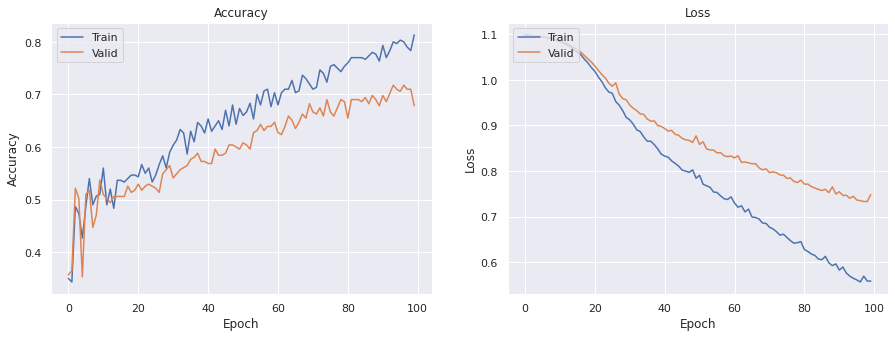

In [96]:
plot_acc_loss(his)

It can be seen from the plots above that the accuracy is much better than the first method used (descriptors matching). Another comment is that this classification takes less time than the first one. Which is really important! 

#### e) Testing the model

The test is done on the test set. And the results are presented by the accuracy and the confusion matrix (defined by the following function)

In [97]:
def predicted_label(model,X_test):
    """
    Compute predictions
    @params:
            - model: neural network model
    @return:
            - list of prediction 
    """
    pred = model.predict(X_test)
    for i in range(len(pred)):
        max_index = np.argmax(list(pred[i]))
        for j in range(3):
          if j==max_index:
            pred[i][j] = 1
          else:
            pred[i][j] = 0
    return pred

def plot_cm(model,Xtest,ytest):
  """
  Plots confusion matrix
  @params:
          - model (neural network): model used for prediction
          - Xtest (array): histogram of test images
          - ytest (categories): categories of test images
  @return:
          plot confusion matrix
  """
  lab_pred = predicted_label(model,Xtest)
  plt.figure(figsize=(10,5))
  cm = confusion_matrix(
          ytest.argmax(axis=1), 
          lab_pred.argmax(axis=1))

  sn.heatmap(cm, annot=True)

In [98]:
# Test the model
y_pred = model.predict(X_test)
a = accuracy_score(np.argmax(y_pred, axis=-1), np.argmax(y_test, axis=-1))
print(f'Accuracy is: {a * 100}')

Accuracy is: 73.33333333333333


 An accuracy of about 73% is obtained. It is clearly doubled compared to the first method even using the optimal threshold. 

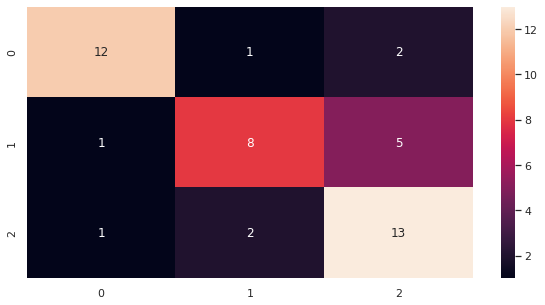

In [99]:
plot_cm(model,X_test,y_test)

From this confusion matrix we deduce that, almorst all the images were well classified. No class had the advantage. There is a good balance in this classification. For example, let look at the category 0, aeroplanes. 12 images over 15 images were well classified. 

## Third Task: Using Convolutional Neural Network to represent Images


---


In this section, a neural network is used for a direct classification on the images

#### a) Resizing images

For proper classification and as the network must receive inputs of the same size, the images are resized so that they are all the same size.  This is done as follows:

In [100]:
image_size = 250
train_set = [resize(cv.imread(image_path+data_train[i]), (image_size, image_size)) for i in range(len(data_train))]
val_set = [resize(cv.imread(image_path+data_val[i]), (image_size, image_size)) for i in range(len(data_val))]

#### b) Loading VGG16 model

Here we use a well-trained model which is the **VGG16** and for which layers will be frozen 

In [101]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# Freeze the layers except the last 4 layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb8f0372b90> False
<keras.layers.convolutional.Conv2D object at 0x7fb965f3f7d0> False
<keras.layers.convolutional.Conv2D object at 0x7fb965f3f6d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb9e21ea990> False
<keras.layers.convolutional.Conv2D object at 0x7fb8f03539d0> False
<keras.layers.convolutional.Conv2D object at 0x7fb9e2308250> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb965f28c90> False
<keras.layers.convolutional.Conv2D object at 0x7fb965f30bd0> False
<keras.layers.convolutional.Conv2D object at 0x7fb965f28bd0> False
<keras.layers.convolutional.Conv2D object at 0x7fb965f86690> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb965f30790> False
<keras.layers.convolutional.Conv2D object at 0x7fb965f58610> False
<keras.layers.convolutional.Conv2D object at 0x7fb9e26a17d0> False
<keras.layers.convolutional.Conv2D object at 0x7fb8f025c310> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb965e7e950>

#### c) Edited neural network architecture


Layers have been added to the tail of the
VGG16:
* **1st layer**: flatten layen to flatten the vgg16 output (because the output of the latter is the input of the next, as the model is sequential)
* **2nd layer**: fully connected layer with a 250 dimesion output and having a Relu activation function
* **3rd layer**: fully connected layer with output size 128 and having a Relu activation function
* 4th layer **bold text**:  fully connected layer with output 3 which is the number of categories and a softmax activation function

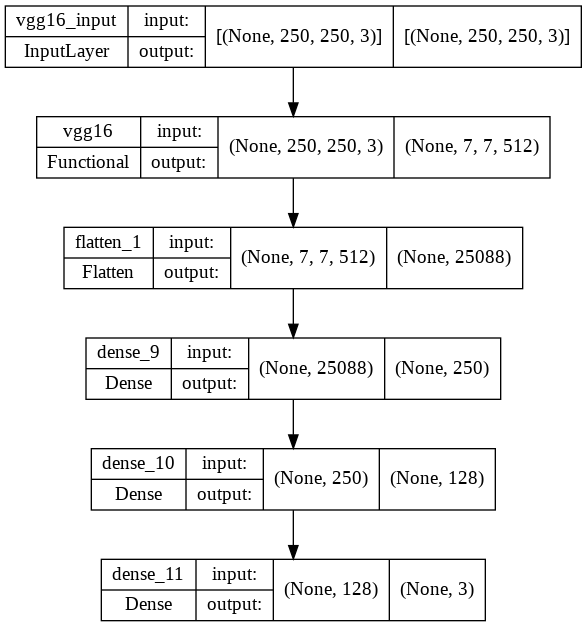

In [102]:
num_classes= 3

model_ = Sequential()
model_.add(vgg)
model_.add(Flatten())
model_.add(Dense(250, activation='relu'))
model_.add(Dense(128, activation='relu'))
model_.add(Dense(num_classes, activation='softmax'))
plot_model(model_, to_file='model2.png', show_shapes=True, show_layer_names=True)

#### d) Compilation

As previously, the **categorical_crossentropy** was used as loss function, the **SGD** as optimizer and the **accuracy** as metric

In [103]:
opt =  tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model_.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### e) Setting device to GPU

(using the gpu speeds up the training)

In [104]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### f) Training the neural network

For training, the hyperparameters are the same number of epochs of 100 and number of batches equal to 64. With also the addition of early stopping.

In [105]:
X_train_ = np.array(train_set)
X_val_ = np.array(val_set)

y_train_ = np.array(train_labels)
y_train_ = y_train_.reshape(-1,1)

y_val_ = np.array(val_labels)
y_val_ = y_val_.reshape(-1,1)

ohe = OneHotEncoder()
y_train_ = ohe.fit_transform(X=y_train_).toarray()
y_val_ = ohe.fit_transform(X=y_val_).toarray()

# Spliting data between train and test
X_val_, X_test_, y_val_, y_test_ = train_test_split(X_val_, y_val_, test_size = 0.15,random_state=42)
#Adding early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

his2 = model_.fit(X_train_, 
                  y_train_,
                  validation_data = (X_val_,y_val_),
                  epochs=100,
                  batch_size=64,
                  callbacks = [early_stopping],verbose=1)

Epoch 1/100
5/5 [==============================] - 8s 2s/step - loss: 1.1053 - accuracy: 0.3800 - val_loss: 1.0753 - val_accuracy: 0.4000
Epoch 2/100
5/5 [==============================] - 7s 1s/step - loss: 1.0472 - accuracy: 0.4400 - val_loss: 1.0255 - val_accuracy: 0.4588
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.9705 - accuracy: 0.5967 - val_loss: 0.9622 - val_accuracy: 0.6353
Epoch 4/100
5/5 [==============================] - 7s 1s/step - loss: 0.8976 - accuracy: 0.7067 - val_loss: 0.8981 - val_accuracy: 0.6902
Epoch 5/100
5/5 [==============================] - 7s 1s/step - loss: 0.8192 - accuracy: 0.8033 - val_loss: 0.8395 - val_accuracy: 0.7412
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.7569 - accuracy: 0.8500 - val_loss: 0.7791 - val_accuracy: 0.7922
Epoch 7/100
5/5 [==============================] - 7s 1s/step - loss: 0.6862 - accuracy: 0.8867 - val_loss: 0.7232 - val_accuracy: 0.8196
Epoch 8/100
5/5 [=================

#### g) Evaluating the model

['loss', 'accuracy', 'val_loss', 'val_accuracy']


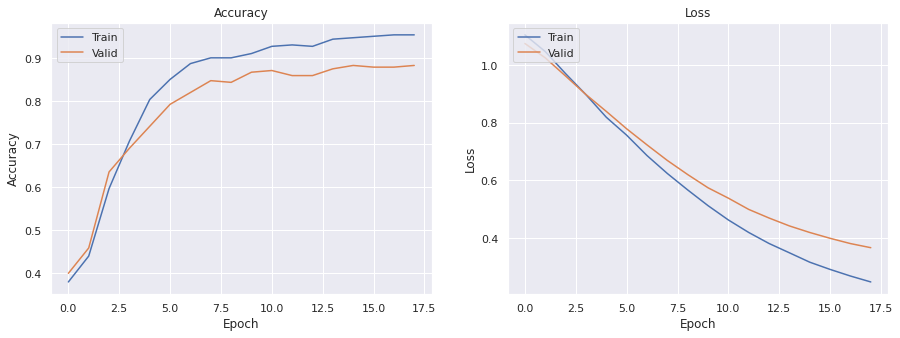

In [106]:
plot_acc_loss(his2)

We clearly see a huge improvement in accuracy. And what is good to notice is that the training lasted only 17 epochs, so it is very efficient (after all, the amount of data is not very large but still). 

#### h) Testing model

In [107]:
# Test the model
y_pred_ = model_.predict(X_test_)
a_ = accuracy_score(np.argmax(y_pred_, axis=-1), np.argmax(y_test_, axis=-1))
print(f'Accuracy is: {a_ * 100}')

Accuracy is: 91.11111111111111


The model reaches **91%** on the test set, which is nearly perfect score.

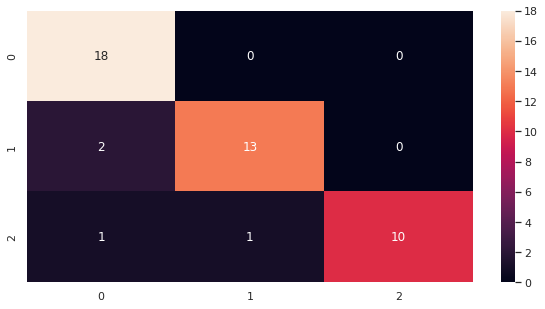

In [108]:
plot_cm(model_,X_test_,y_test_)

We see that the confusion matrix is almost perfect too. let's take a look at what's going on in detail. For the first category, 100% of the images were well classified. The model is however a bit more sensitive to the other categories where in the case of the horses category 2 images were misclassified over a total of 15.  

## Conclusion 


---

To summarize this project, 3 methods have been used for an image retrieval, image search engine construction. The first one was based on the matching of the descriptors, which was not successful. The results were very poor and not at all satisfactory. Then, another method more perfomant than the first one which is the use of the Bag of visual word has been done. It was based on a classification of the histograms of the images. The results were better with an accuracy of **73%**. Finally, an image classification using a CNN has been successfully conducted. With almost perfect and outstanding results (**91%** of accuracy).
I have talked about the accuracy performances but the time performances are even more important. Having a small dataset allowed to measure the time of each method and  compare them. Indeed, despite this size, the first method took a long time to generate the results. A little bit for the second one and much less than the third one especially with the use of the GPU. 

This project allows us to see how neural networks and new methods have somehow revolutionized this field and how important they are nowadays. 